# PROJE BAŞLIĞI: EEG Sinyallerinden Duygu Tanıma
#### VERİ KÜMESİ: DREAMER (Dreaming via Electroencephalogram & Electrocardiogram)
#### YÖNTEM: CNN-LSTM Hibrit Mimarisi + Diferansiyel Entropi (DE) Öznitelikleri

# 1. GİRİŞ VE PROJE ÖZETİ

## 1.1 EEG Tabanlı Duygu Tanıma ve Önemi

Duygu tanıma, insan-bilgisayar etkileşiminde kritik bir rol oynamaktadır.
Geleneksel yöntemler (yüz ifadesi, ses tonu analizi) öznel ve manipüle edilebilir
olduğundan, nörofizyolojik sinyaller üzerinden duygu tanıma önem kazanmıştır.

Elektroensefalografi (EEG), beyin aktivitesini yüksek zamansal çözünürlükle
ölçen invazif olmayan bir yöntemdir. EEG sinyalleri:
- Bilinçli kontrolün dışındadır (objektif ölçüm)
- Milisaniye düzeyinde zamansal çözünürlük sağlar
- Düşük maliyetlidir ve portatif cihazlarla kullanılabilir

## 1.2 DREAMER Veri Kümesi

DREAMER veri kümesi, duygusal video uyaranlarına karşı kaydedilen EEG ve EKG
sinyallerini içerir:
- **23 denek**: Sağlıklı yetişkin bireyler
- **14 kanal EEG**: Uluslararası 10-20 sistemi (AF3, AF4, F3, F4, F7, F8, FC5,
  FC6, T7, T8, P7, P8, O1, O2)
- **18 film klibi**: Her biri yaklaşık 4 dakika uzunluğunda
- **Örnekleme frekansı**: 128 Hz
- **Duygu etiketleri**: Valence (değerlik), Arousal (uyarılmışlık) ve
  Dominance (baskınlık) için 1-5 arası öz-bildirim skorları

Bu çalışmada, yaygın olarak kullanılan iki boyuta odaklanılmıştır:
1. **Valence (Değerlik)**: Olumlu-olumsuz duygu ekseni
2. **Arousal (Uyarılmışlık)**: Sakin-heyecanlı duygu ekseni

## 1.3 Önerilen Yaklaşımın Yenilikçi Yönü

Mevcut literatürde EEG tabanlı duygu tanıma çalışmaları genellikle:
- Sadece CNN mimarileri (uzamsal özellikler)
- Sadece RNN/LSTM mimarileri (zamansal özellikler)
- Ham EEG verisi veya basit istatistiksel özellikler kullanır

**Bu çalışmanın yenilikçi katkıları:**

1. **Hibrit CNN-LSTM Mimarisi**:
   - CNN katmanları: Kanal-frekans bant matrisi üzerindeki yerel uzamsal
     örüntüleri (topoğrafik bilgi) öğrenir
   - LSTM katmanları: Farklı frekans bantları ve kanallar arasındaki
     karmaşık bağımlılıkları ve ardışık ilişkileri modeller

2. **Diferansiyel Entropi (DE) Öznitelikleri**:
   - Ham EEG verisi yerine, her frekans bandı için DE hesaplanır
   - DE, sinyal gücünün logaritmik ölçüsüdür ve duygusal durumlarla yüksek
     korelasyon gösterir (Duan et al., 2013; Zheng & Lu, 2015)
   - 5 frekans bandı (δ, θ, α, β, γ) × 14 kanal = 70 boyutlu kompakt öznitelik

3. **Denek-Bağımsız Değerlendirme (LOSO Cross-Validation)**:
   - Gerçek dünya senaryolarını simüle eder
   - Modelin genelleme yeteneğini daha güvenilir şekilde ölçer
   - Akademik çalışmalarda altın standart olarak kabul edilir

**Hipotez**: Hibrit mimari, hem lokal uzamsal örüntüleri hem de global
zamansal bağımlılıkları yakalayarak, tek başına CNN veya RNN yaklaşımlarından
daha yüksek sınıflandırma başarısı sağlayacaktır.

# 2. KÜTÜPHANE İÇE AKTARIMLARI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [2]:
# Versiyonları kontrol et
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"NumPy Version: {np.__version__}")

TensorFlow Version: 2.19.0
Keras Version: 3.10.0
NumPy Version: 2.0.2


In [3]:
# Rastgelelik kontrolü (tekrarlanabilirlik için)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 3.1 DREAMER Veri Kümesinin Yapısı

DREAMER veri kümesi MATLAB (.mat) formatında saklanır. Yapısı:
- 'DREAMER.mat' dosyası içinde 'DREAMER' adlı yapı dizisi
- Her denek için bir yapı elemanı
- Her yapı: 'Data' (EEG/EKG), 'ScoreValence', 'ScoreArousal', vb. içerir

**Veri Organizasyonu**:
- Data.EEG: (18 deneme × 14 kanal × zaman adımı) boyutlu matris
- ScoreValence/Arousal: (18 deneme × 1) boyutlu etiket vektörü
- Skorlar 1-5 arası (1=çok düşük, 5=çok yüksek)

## 3.2 Veri Yükleme Fonksiyonu

In [4]:
import numpy as np
from scipy.io import loadmat
from pprint import pprint

mat = loadmat('/content/drive/MyDrive/dreamer/DREAMER.mat',
              struct_as_record=False, squeeze_me=True)
d = mat.get('DREAMER')

print("TYPE of DREAMER:", type(d))
print("\nTop-level attributes / fields (filtered):")
attrs = [a for a in dir(d) if not a.startswith('_')]
# Print attribute names and types (first 200 attrs if many)
for name in attrs:
    try:
        val = getattr(d, name)
        print(f" - {name:20} : {type(val)}", end='')
        # Show brief shape/info for arrays
        if isinstance(val, np.ndarray):
            print(f", shape={val.shape}, dtype={val.dtype}")
        else:
            # For simple types print repr clipped
            rep = repr(val)
            print(f", repr={rep[:120] + ('...' if len(rep) > 120 else '')}")
    except Exception as e:
        print(f" - {name:20} : ERROR reading attribute ({e})")

# Now inspect Data field specifically (very likely present per PDF)
data = getattr(d, 'Data', None)
print("\nData attribute found?:", data is not None)
if data is not None:
    print("Data type:", type(data))
    # If ndarray/object array, print length and first element summary
    try:
        # make sure it's iterable
        subjects = np.atleast_1d(data)
        print("Number of subjects in Data (len):", len(subjects))
        first = subjects.flatten()[0]
        print("\nFirst subject type:", type(first))
        first_fields = [f for f in dir(first) if not f.startswith('_')]
        print("First subject field names (sample):", first_fields[:40])
        # Try to show ScoreValence and EEG existence
        print("Has ScoreValence?:", hasattr(first, 'ScoreValence'))
        print("Has ScoreArousal?:", hasattr(first, 'ScoreArousal'))
        print("Has EEG?:", hasattr(first, 'EEG'))
        if hasattr(first, 'ScoreValence'):
            sv = getattr(first, 'ScoreValence')
            print(" ScoreValence type/shape:", type(sv), getattr(sv, 'shape', None), "repr sample:", repr(sv)[:120])
    except Exception as e:
        print("Error while inspecting Data:", e)


TYPE of DREAMER: <class 'scipy.io.matlab._mio5_params.mat_struct'>

Top-level attributes / fields (filtered):
 - Acknowledgement      : <class 'str'>, repr='The authors would like to thank Thomas Cuntz and Sebastian Palke for the data collection under their BSc (Hons) project...
 - Data                 : <class 'numpy.ndarray'>, shape=(23,), dtype=object
 - Disclaimer           : <class 'str'>, repr='While every care has been taken to ensure the accuracy of the data included in the DREAMER dataset, the authors and the...
 - ECG_SamplingRate     : <class 'int'>, repr=256
 - EEG_Electrodes       : <class 'numpy.ndarray'>, shape=(14,), dtype=object
 - EEG_SamplingRate     : <class 'int'>, repr=128
 - Provider             : <class 'str'>, repr='University of the West of Scotland'
 - Version              : <class 'str'>, repr='1.0.2'
 - noOfSubjects         : <class 'int'>, repr=23
 - noOfVideoSequences   : <class 'int'>, repr=18

Data attribute found?: True
Data type: <class 'numpy.ndarray

In [5]:
import numpy as np
from scipy.io import loadmat

def load_dreamer_from_matstruct(mat_path):
    """
    Load DREAMER when mat['DREAMER'] is a mat_struct with Data as subjects.
    Returns:
      eeg_trials : list of ndarray (samples x channels)  -- one item per stimulus trial
      valence_arr : np.ndarray (n_trials,)
      arousal_arr : np.ndarray (n_trials,)
      subject_ids  : np.ndarray (n_trials,) ints 0..n_subjects-1
    """
    mat = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
    if 'DREAMER' not in mat:
        raise ValueError("DREAMER not found in .mat file")
    dreamer = mat['DREAMER']

    # Data should be an array (23 subjects)
    data = getattr(dreamer, 'Data', None)
    if data is None:
        raise ValueError("DREAMER.Data not found. Inspect the mat structure.")
    # ensure iterable list/array of subject structs
    subjects = np.atleast_1d(data).flatten()

    eeg_trials = []
    valence_list = []
    arousal_list = []
    subject_ids = []

    for subj_idx, subj in enumerate(subjects):
        # safe accessors
        score_v = getattr(subj, 'ScoreValence', None)
        score_a = getattr(subj, 'ScoreArousal', None)
        eeg_struct = getattr(subj, 'EEG', None)

        if score_v is None or score_a is None:
            raise ValueError(f"Subject {subj_idx} missing ScoreValence/ScoreArousal fields")

        # Convert scores to 1D numpy arrays
        score_v = np.asarray(score_v).flatten()
        score_a = np.asarray(score_a).flatten()

        if eeg_struct is None:
            raise ValueError(f"Subject {subj_idx} missing EEG field")

        # EEG may have .stimuli as array of 18 trials (or be the stimuli array itself)
        stimuli = getattr(eeg_struct, 'stimuli', None)
        if stimuli is None:
            # fallback to eeg_struct itself (sometimes the stimuli array is stored directly)
            stimuli = eeg_struct

        # normalize to iterable list of trials
        trials = np.atleast_1d(stimuli).flatten()

        for trial_idx, trial in enumerate(trials):
            if trial is None:
                continue
            trial_arr = np.asarray(trial)
            if trial_arr.size == 0:
                continue
            # trial_arr should be (M,14) per PDF. Keep as-is
            eeg_trials.append(trial_arr)
            # align label by trial_idx if available, else np.nan
            if trial_idx < len(score_v):
                valence_list.append(float(score_v[trial_idx]))
                arousal_list.append(float(score_a[trial_idx]))
            else:
                valence_list.append(np.nan)
                arousal_list.append(np.nan)
            subject_ids.append(subj_idx)

    valence_arr = np.array(valence_list)
    arousal_arr = np.array(arousal_list)
    subject_ids = np.array(subject_ids)

    print(f"Loaded {len(subjects)} subjects -> total trials: {len(eeg_trials)}")
    if len(eeg_trials):
        print("Example trial shape (samples x channels):", eeg_trials[0].shape)

    return eeg_trials, valence_arr, arousal_arr, subject_ids

## 3.3 Etiket Dönüştürme: Sürekli → İkili Sınıf

Duygu skorları 1-5 arası sürekli değerlerdir. İkili sınıflandırma için:
- Valence: ≥3 → Pozitif (1), <3 → Negatif (0)
- Arousal: ≥3 → Yüksek (1), <3 → Düşük (0)

**Gerekçe**:
- 3 değeri, 1-5 ölçeğinin orta noktasıdır
- Literatürde yaygın olarak kullanılır (Zhang et al., 2020)
- Dengeli sınıf dağılımı sağlar

In [7]:
# ---------- convert_to_binary_labels (works with 1D numpy of per-trial scores) ----------
def convert_to_binary_labels(scores, threshold=3.0):
    """
    Convert continuous per-trial scores (1D array) into binary labels using threshold.
    scores : ndarray shape (n_trials,)
    """
    scores = np.asarray(scores).flatten()
    binary_labels = (scores >= threshold).astype(int)

    # get counts safely
    unique, counts = np.unique(binary_labels, return_counts=True)
    count_dict = dict(zip(unique, counts))
    c0 = count_dict.get(0, 0)
    c1 = count_dict.get(1, 0)
    total = c0 + c1
    if total > 0:
        balance = (min(c0, c1) / max(c0, c1) * 100) if max(c0, c1) > 0 else 0.0
    else:
        balance = 0.0

    print(f"Sınıf dağılımı - 0: {c0}, 1: {c1}")
    print(f"Denge oranı: {balance:.1f}%")

    return binary_labels

# 4. FREKANS BANDI FİLTRELEME

## 4.1 EEG Frekans Bantları ve Nörofizyolojik Anlam

EEG sinyali, farklı frekans bantlarında önemli bilgiler taşır:

| Bant | Frekans (Hz) | Nörofizyolojik İlişki |
|------|--------------|------------------------|
| δ (Delta) | 0.5-4 | Derin uyku, bilinçsizlik |
| θ (Theta) | 4-8 | Hafif uyku, meditasyon, duygusal işleme |
| α (Alpha) | 8-14 | Rahatlamış uyanıklık, gözler kapalı |
| β (Beta) | 14-30 | Aktif düşünme, konsantrasyon, anksiyete |
| γ (Gamma) | 30-47 | Bilişsel işleme, dikkat |

**Duygu Tanımadaki Rolü**:
- **α bandı**: Pozitif duygularla ilişkili (frontal asimetri)
- **β bandı**: Yüksek arousal ve stres göstergesi
- **θ bandı**: Duygusal hafıza ve işleme
- **γ bandı**: Duygusal uyaranların bilinçli algılanması

## 4.2 Butterworth Band-Pass Filtresi

Butterworth filtresi, frekans bandı ayırma için tercih edilir çünkü:
- Geçirme bandında düz frekans yanıtı sağlar (özellik çarpıtması minimum)
- Faz gecikmesi sıfıra yakındır (filtfilt ile çift yönlü uygulama)
- Numerik kararlılıktır

**Filtre Parametreleri**:
- Sıra (order): 4 (daha yüksek sıra → daha keskin geçiş, daha fazla hesaplama)
- Uygulama: filtfilt (sıfır faz gecikmesi için ileri-geri filtreleme)

In [8]:
# Örnekleme frekansı (DREAMER veri kümesi için)
SAMPLING_FREQ = 128  # Hz

# Frekans bantları tanımı
FREQ_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 47)
}

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Butterworth band-pass filtresi uygular.

    Parametreler:
    -----------
    data : ndarray
        Filtrelenecek sinyal
    lowcut : float
        Alt kesim frekansı (Hz)
    highcut : float
        Üst kesim frekansı (Hz)
    fs : float
        Örnekleme frekansı (Hz)
    order : int
        Filtre sırası

    Dönüş:
    ------
    filtered_data : ndarray
        Filtrelenmiş sinyal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Butterworth filtre katsayıları
    b, a = butter(order, [low, high], btype='band')

    # Sıfır faz gecikmeli filtreleme
    filtered_data = filtfilt(b, a, data, axis=-1)

    return filtered_data

In [9]:
# ---------- Helper: normalize trials to (channels, samples) ----------
def normalize_trials(eeg_trials, expected_channels=14):
    """
    Ensure each trial array has shape (channels, samples).
    Input trials are typically (samples, 14) (as in DREAMER) -> transposed.
    Returns a list of ndarray shaped (channels, samples).
    """
    normalized = []
    for i, tr in enumerate(eeg_trials):
        arr = np.asarray(tr)
        if arr.size == 0:
            continue
        # if shape is (samples, channels) and channels == expected_channels, transpose:
        if arr.ndim == 2 and arr.shape[1] == expected_channels and arr.shape[0] != expected_channels:
            arr = arr.T  # -> (channels, samples)
        elif arr.ndim == 2 and arr.shape[0] == expected_channels:
            # Already channels x samples
            pass
        else:
            # Unexpected shape: try to guess or raise
            # If one dim equals expected_channels, bring it to first axis
            if arr.ndim == 2 and arr.shape[0] == expected_channels:
                pass
            elif arr.ndim == 2 and arr.shape[1] == expected_channels:
                arr = arr.T
            else:
                # last resort: reshape if product matches, but safer to skip
                raise ValueError(f"Trial {i} has unexpected shape {arr.shape}. Expected one axis == {expected_channels}.")
        normalized.append(arr)
    return normalized

# 5. DİFERANSİYEL ENTROPİ (DE) ÖZNİTELİK ÇIKARIMI

## 5.1 Diferansiyel Entropi (DE) Teorik Temeli

Diferansiyel Entropi, Gaussian dağılımlı bir rastgele değişkenin belirsizlik
ölçüsüdür. Bir X rastgele değişkeni için:

    DE(X) = (1/2) * log(2πeσ²)

Burada σ² varyans (güç) ifade eder. EEG sinyali yaklaşık olarak Gaussian
dağılımlı olduğunda:

    DE ≈ (1/2) * log(2πe) + (1/2) * log(var(X))
    DE ≈ (1/2) * log(var(X)) + constant

Sabit terim ihmal edildiğinde:

    DE ≈ log(var(X))

**DE'nin Avantajları**:
1. **Güç spektrumu ile ilişkili**: EEG gücünün logaritmik ölçüsü
2. **Duygusal durumlarla yüksek korelasyon**:
   - Pozitif duygular → α/β bantlarında yüksek DE
   - Negatif duygular → δ/θ bantlarında yüksek DE
3. **Boyut azaltma**: Ham EEG (14 kanal × binlerce örneklem) → Kompakt temsil
4. **Literatürde kanıtlanmış**: Zheng & Lu (2015) %86+ başarı göstermiştir

## 5.2 DE Hesaplama Algoritması

Her bir deneme için:
1. EEG sinyalini frekans bantlarına ayır (5 bant)
2. Her bant için her kanalda varyansı hesapla
3. DE = log(var + ε) (ε: sayısal kararlılık için küçük sabit)
4. Sonuç: (14 kanal × 5 bant) = 70 boyutlu öznitelik vektörü

In [10]:
def compute_differential_entropy(signal):
    """
    Bir sinyal için diferansiyel entropi hesaplar.

    Parametreler:
    -----------
    signal : ndarray
        EEG sinyal kesiti

    Dönüş:
    ------
    de : float
        Diferansiyel entropi değeri
    """
    # Varyans hesapla
    variance = np.var(signal)

    # Sayısal kararlılık için epsilon ekle
    epsilon = 1e-10

    # DE = log(var)
    de = np.log(variance + epsilon)

    return de

## 5.3 Tüm Veri Kümesi için DE Öznitelik Çıkarımı

Bu işlem hesaplama açısından yoğundur:
- 23 denek × 18 deneme = 414 deneme
- Her deneme: 14 kanal × 5 bant filtreleme

In [11]:
# ---------- DE feature extraction adapted to (channels, samples) trials ----------
def extract_de_features(eeg_trial, fs=SAMPLING_FREQ):
    """
    Compute DE features for a single trial.
    eeg_trial: ndarray with shape (channels, samples)  -> (14, T)
    Returns flattened (14 * n_bands,) vector.
    """
    eeg_trial = np.asarray(eeg_trial)
    if eeg_trial.ndim != 2:
        raise ValueError(f"eeg_trial must be 2D (channels, samples). Got shape {eeg_trial.shape}")

    num_channels = eeg_trial.shape[0]
    num_bands = len(FREQ_BANDS)
    de_features = np.zeros((num_channels, num_bands))

    # iterate channels
    for ch_idx in range(num_channels):
        channel_signal = eeg_trial[ch_idx, :]

        for band_idx, (band_name, (low, high)) in enumerate(FREQ_BANDS.items()):
            # Apply bandpass - ensure length > order*3
            try:
                filtered_signal = butter_bandpass_filter(channel_signal, low, high, fs)
            except Exception as e:
                # fallback: if filter fails (too short), compute DE on raw channel
                filtered_signal = channel_signal
            de = compute_differential_entropy(filtered_signal)
            de_features[ch_idx, band_idx] = de

    return de_features.flatten()

# ---------- extract_all_de_features for flat list of trials ----------
def extract_all_de_features(eeg_trials):
    """
    Extract DE features from a flat list of trials. Each trial -> (channels, samples).
    Returns numpy array shape (n_trials, n_features) where n_features = 14 * n_bands.
    """
    print("DE öznitelikleri çıkarılıyor...")

    # normalize shapes (transposes where needed)
    normalized = normalize_trials(eeg_trials, expected_channels=14)

    all_features = []
    total = len(normalized)
    for idx, trial in enumerate(normalized):
        de_feat = extract_de_features(trial)
        all_features.append(de_feat)
        # progress print every 50 or last
        if (idx + 1) % 50 == 0 or (idx + 1) == total:
            print(f"  {idx + 1}/{total} trial işlendi")

    all_features = np.vstack(all_features)  # (n_trials, 70)
    print(f"✓ Öznitelik çıkarımı tamamlandı: {all_features.shape}")

    return all_features

# 6. VERİ SETİ HAZIRLIĞI VE NORMALLEŞTIRME

## 6.1 Leave-One-Subject-Out (LOSO) Çapraz Doğrulama

**LOSO Yaklaşımının Önemi**:

Geleneksel rastgele bölme (train/test split), aynı denekten farklı denemeleri
hem eğitim hem de test setine yerleştirebilir. Bu, yapay olarak yüksek başarı
ölçümlerine yol açar çünkü:
- Her bireyin benzersiz EEG özellikleri vardır
- Model, belirli bir bireye "overfitting" yapabilir

**LOSO Çözümü**:
- Her iterasyonda, bir denek tamamen test setine ayrılır
- Kalan 22 denek eğitim için kullanılır
- 23 iterasyon sonunda, her deneğin test sonucu elde edilir
- Gerçek dünya senaryosunu simüle eder (yeni bir kullanıcı için tahmin)

**Akademik Gerekçe**:
- "Subject-independent" değerlendirme literatürde altın standarttır
- Daha düşük başarı oranları, daha güvenilir sonuçlardır
- İyi modeller %65-80 arası başarı gösterir (subject-dependent %85-95)

## 6.2 Veri Normalleştirme (Standardization)

**Z-score Normalleştirme**:
    x_normalized = (x - μ) / σ

**Neden Gerekli**:
- Farklı frekans bantlarının güç seviyeleri farklıdır (örn: α >> γ)
- Gradyan iniş optimizasyonu için ölçek tutarlılığı gerekir
- Modelin yakınsama hızını artırır

**LOSO'da Önemli Nokta**:
- Her fold için StandardScaler, sadece eğitim verisi üzerinde fit edilir
- Test verisi, eğitim verisinin μ ve σ değerleri ile normalize edilir
- Bu, veri sızıntısını (data leakage) önler

In [12]:
def prepare_loso_folds(features, labels, subject_ids):
    """
    LOSO çapraz doğrulama için veri katlarını hazırlar.

    Parametreler:
    -----------
    features : ndarray
        Öznitelik matrisi (N × 70)
    labels : ndarray
        Etiket vektörü (N,)
    subject_ids : ndarray
        Denek kimlikleri (N,)

    Dönüş:
    ------
    folds : list of tuples
        Her fold için (X_train, X_test, y_train, y_test) tuple'ları
    """
    logo = LeaveOneGroupOut()
    folds = []

    print(f"LOSO: {len(np.unique(subject_ids))} fold oluşturuluyor...")

    for train_idx, test_idx in logo.split(features, labels, subject_ids):
        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Normalleştirme (sadece eğitim verisi üzerinde fit)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        folds.append((X_train, X_test, y_train, y_test))

    print(f"✓ {len(folds)} fold hazırlandı")

    return folds

# 7. HİBRİT CNN-LSTM MODEL MİMARİSİ

## 7.1 Mimari Tasarım Felsefesi

**Neden Hibrit Mimari?**

1. **CNN Katmanları**:
   - Amaç: 14 kanal × 5 bant matrisindeki yerel uzamsal örüntüleri yakalamak
   - Topoğrafik bilgi: Komşu elektrotlar ve frekans bantları arasındaki ilişki
   - Örnek: Frontal bölgede α bandı simetrisi (duygu lateralizasyonu)

2. **LSTM Katmanları**:
   - Amaç: Farklı kanallar ve bantlar arasındaki global bağımlılıkları öğrenmek
   - 70 boyutlu vektördeki ardışık ilişkileri modellemek
   - Uzun vadeli bağımlılıkları yakalamak

## 7.2 Önerilen Mimari Detayları

**Katman Yapısı**:
1. Giriş: (70,) → Reshape → (14, 5, 1) [Kanal, Bant, Kanal-sayısı]
2. Conv2D Blokları: Yerel örüntü tespiti
   - İlk Conv: 64 filtre (3×3) → BatchNorm → ReLU → MaxPool
   - İkinci Conv: 128 filtre (3×3) → BatchNorm → ReLU → MaxPool
3. Flatten → Reshape: CNN çıktısını LSTM için hazırla
4. LSTM Katmanı: 64 unit, return_sequences=False
5. Dropout: Overfitting önleme (0.5)
6. Dense Çıkış: 2 sınıf (softmax)

**Hiperparametre Gerekçeleri**:
- **Filtre sayıları (64, 128)**: Yeteri kadar kapasite, aşırı karmaşıklık yok
- **Kernel boyutu (3×3)**: 5×5'e göre daha az parametre, 2×2'ye göre daha fazla bağlam
- **LSTM unit sayısı (64)**: Dengeli öğrenme kapasitesi
- **Dropout (0.5)**: Standart regularizasyon değeri

In [13]:
def build_hybrid_cnn_lstm_model(input_shape=(70,), num_classes=2):
    """
    Hibrit CNN-LSTM modeli oluşturur.

    Parametreler:
    -----------
    input_shape : tuple
        Giriş şekli (70,)
    num_classes : int
        Sınıf sayısı (2 - ikili sınıflandırma)

    Dönüş:
    ------
    model : keras.Model
        Derlenmemiş Keras modeli
    """

    inputs = keras.Input(shape=input_shape, name='input_features')

    # 70 boyutlu vektörü (14, 5, 1) matrise dönüştür
    # 14 kanal, 5 frekans bandı, 1 öznitelik kanalı
    x = layers.Reshape((14, 5, 1), name='reshape_to_2d')(inputs)

    # ==================== CNN BLOKLARI ====================

    # CNN Blok 1
    x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name='conv2d_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Activation('relu', name='relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)

    # CNN Blok 2
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name='conv2d_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Activation('relu', name='relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # CNN çıktısını düzleştir
    x = layers.Flatten(name='flatten')(x)

    # ==================== LSTM BLOKLARI ====================

    # LSTM için yeniden şekillendir: (batch, timesteps, features)
    # Flatten çıktısını zaman adımlarına böl
    x = layers.Reshape((-1, 128), name='reshape_for_lstm')(x)

    # LSTM Katmanı
    x = layers.LSTM(64, return_sequences=False, name='lstm_1')(x)
    x = layers.Dropout(0.5, name='dropout_lstm')(x)

    # ==================== ÇIKIŞ KATMANI ====================

    # Tam bağlı katman
    x = layers.Dense(32, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.4, name='dropout_dense')(x)

    # Çıkış katmanı
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    # Model oluştur
    model = keras.Model(inputs=inputs, outputs=outputs, name='Hybrid_CNN_LSTM')

    return model

## 7.3 Model Derleme ve Optimizasyon Parametreleri

**Kayıp Fonksiyonu**: Sparse Categorical Crossentropy
- İkili sınıflandırma için uygun
- Etiketler one-hot encoded değil, integer formatında (0, 1)

**Optimizasyon**: Adam
- Adaptif öğrenme oranı
- Momentum ve RMSprop'un avantajlarını birleştirir
- Başlangıç öğrenme oranı: 0.001 (standart)

**Metrikler**:
- Model Keras tarafında yalnızca Sparse Categorical Accuracy ile derlenir.
   - Bu metrik, sınıf etiketleri integer olduğu için güvenli ve standarttır.
- Precision, Recall ve F1-Score, Keras içinde değil,
   - tahminler alındıktan sonra sklearn kullanılarak hesaplanacaktır.
- Bu yaklaşım:
   - Keras’ın bazı durumlarda hatalı Precision/Recall göstermesini önler,
   - Çok sınıflı görevlerde daha güvenilir sonuçlar elde etmenizi sağlar.

In [14]:
def compile_model(model, learning_rate=0.001):
    """
    Compile model without Keras Precision/Recall (compute them with sklearn after predictions).
    """
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']  # keep a safe accuracy metric
    )

    return model

# 8. MODEL EĞİTİMİ VE LOSO ÇAPRAZ DOĞRULAMA

## 8.1 Callback Fonksiyonları

**EarlyStopping**:
- Amaç: Overfitting'i önlemek
- İzlenen metrik: Doğrulama kaybı (val_loss)
- Sabır (patience): 15 epoch (iyileşme yoksa durdur)
- Mod: 'min' (kayıp minimize edilmeli)

**ModelCheckpoint**:
- Amaç: En iyi modeli kaydetmek
- Kriter: En düşük doğrulama kaybı
- save_best_only: True (sadece iyileşme olduğunda kaydet)

**ReduceLROnPlateau**:
- Amaç: Öğrenme oranını dinamik azaltmak
- Plato tespit edildiğinde (5 epoch iyileşme yok) → LR × 0.5
- Minimum LR: 1e-6

Bu callback'ler, modelin optimal yakınsamasını ve genelleme yeteneğini artırır.

In [15]:
def create_callbacks(fold_idx, emotion_type):
    """
    Eğitim callback'lerini oluşturur.

    Parametreler:
    -----------
    fold_idx : int
        Fold numarası
    emotion_type : str
        'valence' veya 'arousal'

    Dönüş:
    ------
    callbacks_list : list
        Callback nesneleri listesi
    """

    # Early stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint
    checkpoint_path = f'best_model_{emotion_type}_fold{fold_idx}.h5'
    model_checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # Learning rate reduction
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [early_stop, model_checkpoint, reduce_lr]

## 8.2 LOSO Çapraz Doğrulama Eğitim Döngüsü

Her fold için:
1. Yeni bir model oluştur (transfer learning yok, her fold bağımsız)
2. Eğitim setinin %15'ini doğrulama için ayır
3. Model eğit (maksimum 100 epoch, early stopping ile)
4. Test setinde değerlendir
5. Tahminleri ve metrikleri sakla

Toplam 23 fold sonunda:
- Ortalama ve standart sapma hesapla
- Tüm tahminleri birleştirerek global metrikler hesapla

In [16]:
def train_loso_cross_validation(folds, emotion_type, epochs=100, batch_size=32):
    """
    LOSO cross-validation training. Computes precision/recall/f1 with sklearn after each fold.
    """
    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} İÇİN LOSO ÇAPRAZ DOĞRULAMA EĞİTİMİ")
    print(f"{'='*70}\n")

    fold_accuracies = []
    fold_f1_scores = []
    fold_precisions = []
    fold_recalls = []
    all_predictions = []
    all_true_labels = []
    histories = []

    for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds):
        print(f"\n--- Fold {fold_idx + 1}/{len(folds)} ---")
        print(f"Eğitim boyutu: {X_train.shape[0]}, Test boyutu: {X_test.shape[0]}")

        # Yeni model oluştur
        model = build_hybrid_cnn_lstm_model()
        model = compile_model(model)

        # Callbacks
        fold_callbacks = create_callbacks(fold_idx, emotion_type)

        # Model eğitimi
        history = model.fit(
            X_train, y_train,
            validation_split=0.15,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=fold_callbacks,
            verbose=1  # set to 1 to see training progress per fold
        )

        # Test tahminleri (probabilities -> class indices)
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Convert to numpy arrays (ensure shapes)
        y_test_arr = np.asarray(y_test).flatten()
        y_pred_arr = np.asarray(y_pred).flatten()

        # Metrikler (sklearn)
        accuracy = accuracy_score(y_test_arr, y_pred_arr)
        f1 = f1_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)
        precision = precision_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)
        recall = recall_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_precisions.append(precision)
        fold_recalls.append(recall)

        all_predictions.extend(y_pred_arr.tolist())
        all_true_labels.extend(y_test_arr.tolist())
        histories.append(history)

        print(f"  Test Accuracy: {accuracy*100:.2f}%")
        print(f"  Test Precision (weighted): {precision*100:.2f}%")
        print(f"  Test Recall (weighted): {recall*100:.2f}%")
        print(f"  Test F1-Score (weighted): {f1*100:.2f}%")

    # Toplam sonuçlar
    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} SONUÇLARI")
    print(f"{'='*70}")
    print(f"Ortalama Accuracy: {np.mean(fold_accuracies)*100:.2f}% ± {np.std(fold_accuracies)*100:.2f}%")
    print(f"Ortalama Precision: {np.mean(fold_precisions)*100:.2f}% ± {np.std(fold_precisions)*100:.2f}%")
    print(f"Ortalama Recall: {np.mean(fold_recalls)*100:.2f}% ± {np.std(fold_recalls)*100:.2f}%")
    print(f"Ortalama F1-Score: {np.mean(fold_f1_scores)*100:.2f}% ± {np.std(fold_f1_scores)*100:.2f}%")

    results = {
        'fold_accuracies': fold_accuracies,
        'fold_f1_scores': fold_f1_scores,
        'fold_precisions': fold_precisions,
        'fold_recalls': fold_recalls,
        'all_predictions': np.array(all_predictions),
        'all_true_labels': np.array(all_true_labels),
        'histories': histories,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'mean_f1': np.mean(fold_f1_scores),
        'std_f1': np.std(fold_f1_scores),
        'mean_precision': np.mean(fold_precisions),
        'std_precision': np.std(fold_precisions),
        'mean_recall': np.mean(fold_recalls),
        'std_recall': np.std(fold_recalls)
    }

    return results

## 9.1 Eğitim Geçmişi Görselleştirme

Eğitim ve doğrulama kayıp/başarı grafikleri:
- Overfitting tespiti (eğitim-doğrulama ayrışması)
- Yakınsama analizi
- Early stopping etkisi

In [17]:
def plot_training_history(histories, emotion_type):
    """
    Tüm fold'ların eğitim geçmişini görselleştirir.

    Parametreler:
    -----------
    histories : list
        Keras History nesneleri
    emotion_type : str
        'valence' veya 'arousal'
    """
    # Safety checks
    if histories is None or len(histories) == 0:
        print("No training histories to plot.")
        return

    # Determine accuracy key (some runs use 'accuracy', others 'sparse_categorical_accuracy')
    sample_hist = histories[0].history
    acc_key = None
    for k in sample_hist.keys():
        if 'accuracy' in k and not k.startswith('val_'):
            acc_key = k
            break
    if acc_key is None:
        # fallback to 'accuracy'
        acc_key = 'accuracy'

    val_acc_key = 'val_' + acc_key

    # Find minimum epoch length across all histories (truncate longer histories)
    epoch_lengths = [len(h.history.get('loss', [])) for h in histories]
    min_epochs = min(epoch_lengths)
    if min_epochs == 0:
        print("Histories present but no epoch records found.")
        return

    # Build arrays truncated to min_epochs
    train_losses = np.array([h.history['loss'][:min_epochs] for h in histories])
    val_losses = np.array([h.history.get('val_loss', [np.nan]*min_epochs)[:min_epochs] for h in histories])

    train_accs = np.array([h.history.get(acc_key, [np.nan]*min_epochs)[:min_epochs] for h in histories])
    val_accs = np.array([h.history.get(val_acc_key, [np.nan]*min_epochs)[:min_epochs] for h in histories])

    # Compute means across folds (axis=0)
    avg_train_loss = np.nanmean(train_losses, axis=0)
    avg_val_loss = np.nanmean(val_losses, axis=0)
    avg_train_acc = np.nanmean(train_accs, axis=0)
    avg_val_acc = np.nanmean(val_accs, axis=0)

    epochs_range = range(1, min_epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{emotion_type.upper()} - Eğitim Geçmişi (Ortalama, {min_epochs} epoch)', fontsize=14, fontweight='bold')

    # Loss plot
    axes[0].plot(epochs_range, avg_train_loss, label='Eğitim Kaybı', linewidth=2)
    axes[0].plot(epochs_range, avg_val_loss, label='Doğrulama Kaybı', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Kayıp', fontsize=12)
    axes[0].set_title('Model Kaybı', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(epochs_range, avg_train_acc, label='Eğitim Başarısı', linewidth=2)
    axes[1].plot(epochs_range, avg_val_acc, label='Doğrulama Başarısı', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Başarı', fontsize=12)
    axes[1].set_title('Model Başarısı', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 9.2 Karmaşıklık Matrisi (Confusion Matrix)

Karmaşıklık matrisi, modelin hangi sınıfları karıştırdığını gösterir:
- Köşegen elemanlar: Doğru sınıflandırmalar
- Köşegen dışı: Hatalı sınıflandırmalar

**Yorumlama**:
- Yüksek recall, düşük precision → Çok fazla pozitif tahmin
- Düşük recall, yüksek precision → Çok muhafazakar tahmin

In [18]:
def plot_confusion_matrix(y_true, y_pred, emotion_type):
    """
    Karmaşıklık matrisini görselleştirir.

    Parametreler:
    -----------
    y_true : ndarray
        Gerçek etiketler
    y_pred : ndarray
        Tahmin edilen etiketler
    emotion_type : str
        'valence' veya 'arousal'
    """

    cm = confusion_matrix(y_true, y_pred)

    # Sınıf isimleri
    if emotion_type == 'valence':
        class_names = ['Negatif', 'Pozitif']
    else:
        class_names = ['Düşük', 'Yüksek']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Sayı'})
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek', fontsize=12)
    plt.title(f'{emotion_type.upper()} - Karmaşıklık Matrisi',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Normalize edilmiş versiyon
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Oran'})
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek', fontsize=12)
    plt.title(f'{emotion_type.upper()} - Normalize Karmaşıklık Matrisi',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 9.3 Detaylı Sınıflandırma Raporu

sklearn'ın classification_report fonksiyonu, her sınıf için:
- Precision: TP / (TP + FP)
- Recall: TP / (TP + FN)
- F1-Score: 2 × (Precision × Recall) / (Precision + Recall)
- Support: Her sınıftaki örnek sayısı

değerlerini hesaplar.

In [19]:
def print_classification_report(y_true, y_pred, emotion_type):
    """
    Detaylı sınıflandırma raporunu yazdırır.

    Parametreler:
    -----------
    y_true : ndarray
        Gerçek etiketler
    y_pred : ndarray
        Tahmin edilen etiketler
    emotion_type : str
        'valence' veya 'arousal'
    """

    if emotion_type == 'valence':
        target_names = ['Negatif', 'Pozitif']
    else:
        target_names = ['Düşük', 'Yüksek']

    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} - SINIFLANDIRMA RAPORU")
    print(f"{'='*70}\n")

    report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
    print(report)

# 10. ANA EĞİTİM PİPELINE

## 10.1 Veri Yükleme ve Ön İşleme Pipeline

Veri kümesi: https://zenodo.org/records/546113

# VERİ YOLU AYARI

In [20]:
DATA_PATH = "/content/drive/MyDrive/dreamer/DREAMER.mat"

In [21]:
# Örnek kullanım için veri yolu kontrolü
import os

if not os.path.exists(DATA_PATH):
    print("="*70)
    print("  UYARI: DREAMER.mat dosyası bulunamadı!")
    print("="*70)
    print("\nLütfen aşağıdaki adımları takip edin:")
    print("1. DREAMER veri kümesini indirin:")
    print("   http://www.eecs.qmul.ac.uk/mmv/datasets/dreamer/")
    print("2. DREAMER.mat dosyasının yolunu DATA_PATH değişkenine atayın")
    print("3. Notebook'u yeniden çalıştırın")
    USE_DEMO_DATA = True
else:
    USE_DEMO_DATA = False
    print(f"✓ Veri dosyası bulundu: {DATA_PATH}")

✓ Veri dosyası bulundu: /content/drive/MyDrive/dreamer/DREAMER.mat


## 10.3 Ana Eğitim Fonksiyonu

In [22]:
def main_pipeline():
    """
    Uçtan uca eğitim pipeline'ı.
    """

    print("\n" + "="*70)
    print("  DREAMER EEG DUYGU TANIMA PROJESİ")
    print("  Hibrit CNN-LSTM Mimarisi + DE Öznitelikleri")
    print("="*70 + "\n")

    # 1. Veri Yükleme
    eeg_trials, valence_arr, arousal_arr, subject_ids = load_dreamer_from_matstruct(DATA_PATH)

    # 2. İkili Etiket Dönüşümü
    print("\n--- İkili Etiket Dönüşümü ---")
    print("Valence:")
    valence_binary = convert_to_binary_labels(valence_arr, threshold=3.0)
    print("\nArousal:")
    arousal_binary = convert_to_binary_labels(arousal_arr, threshold=3.0)

    # 3. DE Öznitelik Çıkarımı
    print("\n--- DE Öznitelik Çıkarımı ---")
    features = extract_all_de_features(eeg_trials)

    print(f"\nÖznitelik matrisi şekli: {features.shape}")
    print(f"Valence etiket şekli: {valence_binary.shape}")
    print(f"Arousal etiket şekli: {arousal_binary.shape}")

    # 4. LOSO Fold Hazırlama - VALENCE
    print("\n--- VALENCE için LOSO Fold Hazırlama ---")
    valence_folds = prepare_loso_folds(features, valence_binary, subject_ids)

    # 5. LOSO Fold Hazırlama - AROUSAL
    print("\n--- AROUSAL için LOSO Fold Hazırlama ---")
    arousal_folds = prepare_loso_folds(features, arousal_binary, subject_ids)

    # 6. Model Eğitimi - VALENCE
    valence_results = train_loso_cross_validation(
        valence_folds,
        emotion_type='valence',
        epochs=100,
        batch_size=32
    )

    # 7. Model Eğitimi - AROUSAL
    arousal_results = train_loso_cross_validation(
        arousal_folds,
        emotion_type='arousal',
        epochs=100,
        batch_size=32
    )

    # 8. Sonuçların Görselleştirilmesi
    print("\n--- Sonuçlar Görselleştiriliyor ---")

    # Valence sonuçları
    plot_training_history(valence_results['histories'], 'valence')
    plot_confusion_matrix(
        valence_results['all_true_labels'],
        valence_results['all_predictions'],
        'valence'
    )
    print_classification_report(
        valence_results['all_true_labels'],
        valence_results['all_predictions'],
        'valence'
    )

    # Arousal sonuçları
    plot_training_history(arousal_results['histories'], 'arousal')
    plot_confusion_matrix(
        arousal_results['all_true_labels'],
        arousal_results['all_predictions'],
        'arousal'
    )
    print_classification_report(
        arousal_results['all_true_labels'],
        arousal_results['all_predictions'],
        'arousal'
    )

    # 9. Özet Tablo
    print("\n" + "="*70)
    print("  FİNAL SONUÇLAR ÖZETİ")
    print("="*70 + "\n")

    summary = pd.DataFrame({
        'Duygu Boyutu': ['Valence', 'Arousal'],
        'Ortalama Accuracy (%)': [
            f"{valence_results['mean_accuracy']*100:.2f} ± {valence_results['std_accuracy']*100:.2f}",
            f"{arousal_results['mean_accuracy']*100:.2f} ± {arousal_results['std_accuracy']*100:.2f}"
        ],
        'Ortalama F1-Score (%)': [
            f"{valence_results['mean_f1']*100:.2f} ± {valence_results['std_f1']*100:.2f}",
            f"{arousal_results['mean_f1']*100:.2f} ± {arousal_results['std_f1']*100:.2f}"
        ]
    })

    print(summary.to_string(index=False))
    print("\n" + "="*70)

    return valence_results, arousal_results

# 11. NOTEBOOK ÇALIŞTIRMA

## 11.2 Beklenen Sonuçlar

**Literatür Karşılaştırması**:
- DEAP veri kümesi (benzer): %75-85 (subject-independent)
- DREAMER veri kümesi:
  - Katsouris & Garoufallou (2021): %79.2 (Valence), %82.1 (Arousal)
  - Li et al. (2018): %83.6 (Valence), %85.2 (Arousal) - subject-dependent

**Bu Çalışmadan Beklenen**:
- Valence: %70-80 (subject-independent)
- Arousal: %72-82 (subject-independent)
- Hibrit mimari sayesinde, tek mimari yaklaşımlardan %3-5 daha iyi

## 11.3 Sonuçların Yorumlanması

**Yüksek Başarı Göstergeleri**:
- F1-Score > 0.75: İyi genelleme
- Düşük standart sapma (< 0.05): Tutarlı performans
- Balanced confusion matrix: Her iki sınıfı da iyi öğrenmiş

**Düşük Başarı Nedenleri**:
- Bireysel farklılıklar (LOSO'da beklenen)
- Veri dengesizliği
- Etiket kalitesi (öz-bildirim skorları subjektif)

**İyileştirme Önerileri**:
- Data augmentation (zaman ölçekleme, gürültü ekleme)
- Transfer learning (başka veri kümeleri ile ön-eğitim)
- Ensemble yöntemler (birden fazla modelin birleşimi)
- Attention mekanizmaları (önemli kanalları vurgulama)


  DREAMER EEG DUYGU TANIMA PROJESİ
  Hibrit CNN-LSTM Mimarisi + DE Öznitelikleri

Loaded 23 subjects -> total trials: 414
Example trial shape (samples x channels): (25472, 14)

--- İkili Etiket Dönüşümü ---
Valence:
Sınıf dağılımı - 0: 161, 1: 253
Denge oranı: 63.6%

Arousal:
Sınıf dağılımı - 0: 114, 1: 300
Denge oranı: 38.0%

--- DE Öznitelik Çıkarımı ---
DE öznitelikleri çıkarılıyor...
  50/414 trial işlendi
  100/414 trial işlendi
  150/414 trial işlendi
  200/414 trial işlendi
  250/414 trial işlendi
  300/414 trial işlendi
  350/414 trial işlendi
  400/414 trial işlendi
  414/414 trial işlendi
✓ Öznitelik çıkarımı tamamlandı: (414, 70)

Öznitelik matrisi şekli: (414, 70)
Valence etiket şekli: (414,)
Arousal etiket şekli: (414,)

--- VALENCE için LOSO Fold Hazırlama ---
LOSO: 23 fold oluşturuluyor...
✓ 23 fold hazırlandı

--- AROUSAL için LOSO Fold Hazırlama ---
LOSO: 23 fold oluşturuluyor...
✓ 23 fold hazırlandı

  VALENCE İÇİN LOSO ÇAPRAZ DOĞRULAMA EĞİTİMİ


--- Fold 1/23 ---
Eğ

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.7394 - sparse_categorical_accuracy: 0.4894 - val_loss: 0.6785 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.5838 - val_loss: 0.6798 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6900 - sparse_categorical_accuracy: 0.5907 - val_loss: 0.6869 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6858 - sparse_categorical_accuracy: 0.5923 - val_loss: 0.6849 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6804 - sparse_categorical_accuracy: 0.5679 - val_loss: 0.6825 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6622 - sparse_categorical_accuracy: 0.5864 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.5925

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.5932 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6773 - sparse_categorical_accuracy: 0.5902 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.6336

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6648 - sparse_categorical_accuracy: 0.6329 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6076

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6747 - sparse_categorical_accuracy: 0.6083 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6003

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6520 - sparse_categorical_accuracy: 0.6015 - val_loss: 0.6753 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 15/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6573 - sparse_categorical_accuracy: 0.6065

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6081 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6682 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.6754 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6670 - sparse_categorical_accuracy: 0.5748 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.6003 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6389

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6438 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6716 - sparse_categorical_accuracy: 0.6141 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6634 - sparse_categorical_accuracy: 0.5827 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6458 - sparse_categorical_accuracy: 0.5960 - val_loss: 0.6779 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 23/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6080 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.5344 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7122 - sparse_categorical_accuracy: 0.5959 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6435 - sparse_categorical_accuracy: 0.5900 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7040 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7009 - sparse_categorical_accuracy: 0.6093

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6996 - sparse_categorical_accuracy: 0.6079 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.5971

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.6026 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6785 - sparse_categorical_accuracy: 0.6141

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.6153 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.6122

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.6098 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.6369 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6615 - sparse_categorical_accuracy: 0.5879

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.6621 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6066

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6679 - sparse_categorical_accuracy: 0.6059 - val_loss: 0.6607 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.6152

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.6123 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6788 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.6310 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.6292

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.6293 - val_loss: 0.6603 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.6450

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6765 - sparse_categorical_accuracy: 0.6011 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.6114 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6672 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6691 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.6618 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6605 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.6580 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 23/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6687 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 24/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6642 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6162 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.6319

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6302 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6763 - sparse_categorical_accuracy: 0.5957

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6703 - sparse_categorical_accuracy: 0.6025 - val_loss: 0.6554 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6414 - sparse_categorical_accuracy: 0.6453 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.6341 - val_loss: 0.6556 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 31/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.6526

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.6495 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 32/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.6636

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.6594 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.6397 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 34/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.6463

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6437 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6321 - sparse_categorical_accuracy: 0.6299 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6238 - sparse_categorical_accuracy: 0.6323 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.6332

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.6363 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 38/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.6186

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 39/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.6837

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.6799 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.6642

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.6061

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6463 - sparse_categorical_accuracy: 0.6079 - val_loss: 0.6472 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.6475 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6249 - sparse_categorical_accuracy: 0.6566 - val_loss: 0.6502 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6120 - sparse_categorical_accuracy: 0.6308 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6103 - sparse_categorical_accuracy: 0.6572 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 46/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.5133 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6980 - sparse_categorical_accuracy: 0.5576 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7033 - sparse_categorical_accuracy: 0.5662 - val_loss: 0.6853 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.5328 - val_loss: 0.6801 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.5634

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.5657 - val_loss: 0.6765 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.6063

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.6045 - val_loss: 0.6753 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.6406

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.6730 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5744 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.5574 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.5859 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.7394 - sparse_categorical_accuracy: 0.5102 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6851 - sparse_categorical_accuracy: 0.5813 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.5246 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6779 - sparse_categorical_accuracy: 0.6189

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6801 - sparse_categorical_accuracy: 0.6254 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.6045 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.5903

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.5867 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7014 - sparse_categorical_accuracy: 0.5913

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.5904 - val_loss: 0.6683 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6628 - sparse_categorical_accuracy: 0.6305

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6616 - sparse_categorical_accuracy: 0.6218 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6630 - sparse_categorical_accuracy: 0.6348

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.6295 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6734 - sparse_categorical_accuracy: 0.5986 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6696 - sparse_categorical_accuracy: 0.5953 - val_loss: 0.6693 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6641 - sparse_categorical_accuracy: 0.6140 - val_loss: 0.6704 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.6200 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.7207 - sparse_categorical_accuracy: 0.5506 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.6339

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.6198 - val_loss: 0.6784 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.5618

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297 - sparse_categorical_accuracy: 0.5599 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.6204

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6630 - sparse_categorical_accuracy: 0.5829

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6657 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.6737 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6368 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.6740 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6739 - sparse_categorical_accuracy: 0.6457

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.6412 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6713 - sparse_categorical_accuracy: 0.6049 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.5529 - val_loss: 0.6752 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.5961 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6747 - sparse_categorical_accuracy: 0.5812 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.6193 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.6139 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6541 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6460 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 22/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.6360

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.6372 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 23/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6370 - sparse_categorical_accuracy: 0.6369

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 24/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.6391

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6309 - val_loss: 0.6678 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 25/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.6817

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.6171 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.6558 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6493 - sparse_categorical_accuracy: 0.5940 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.5855 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 32/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6202 - sparse_categorical_accuracy: 0.6807

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.6643 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 33/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.6734

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.6661 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 34/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.6640

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 35/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6210 - sparse_categorical_accuracy: 0.6588

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.6519 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6041 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.6614 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.6414

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6367 - val_loss: 0.6561 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 39/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.6724

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.6526 - val_loss: 0.6534 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.6612 - val_loss: 0.6550 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.6579 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 42/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6161 - sparse_categorical_accuracy: 0.6842

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 43/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6162 - sparse_categorical_accuracy: 0.6788

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6163 - sparse_categorical_accuracy: 0.6736 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6072 - sparse_categorical_accuracy: 0.6523

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.6528 - val_loss: 0.6480 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 45/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6058 - sparse_categorical_accuracy: 0.6620

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6077 - sparse_categorical_accuracy: 0.6652 - val_loss: 0.6457 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 5.0000e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6155 - sparse_categorical_accuracy: 0.6378 - val_loss: 0.6465 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 5.0000e-04
Epoch 48/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.7305

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5935 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 5.0000e-04
Epoch 49/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6247 - sparse_categorical_accuracy: 0.6358

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6242 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.6431 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 5.0000e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6189 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 5.0000e-04
Epoch 51/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.6367

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.6392 - val_loss: 0.6428 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 5.0000e-04
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5950 - sparse_categorical_accuracy: 0.6881 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.7103

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.6418 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 54/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5978 - sparse_categorical_accuracy: 0.6691

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.6654 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6386 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 5.0000e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6028 - sparse_categorical_accuracy: 0.6642 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 5.0000e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6039 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.6475 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 58/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.6519 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 59/100
 8/11 ━━━━━━━━━━━━━━━━━━━

  Test Accuracy: 55.56%
  Test Precision (weighted): 35.95%
  Test Recall (weighted): 55.56%
  Test F1-Score (weighted): 43.65%

--- Fold 6/23 ---
Eğitim boyutu: 396, Test boyutu: 18
Epoch 1/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7873 - sparse_categorical_accuracy: 0.5027

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.7825 - sparse_categorical_accuracy: 0.5057 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6962 - sparse_categorical_accuracy: 0.5917

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.5803 - val_loss: 0.6775 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7134 - sparse_categorical_accuracy: 0.5007 - val_loss: 0.6793 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7009 - sparse_categorical_accuracy: 0.5069 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6681 - sparse_categorical_accuracy: 0.5655

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.5689 - val_loss: 0.6752 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.5663

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6728 - sparse_categorical_accuracy: 0.5652 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6824 - sparse_categorical_accuracy: 0.5949 - val_loss: 0.6740 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5686

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6831 - sparse_categorical_accuracy: 0.5683 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6846 - sparse_categorical_accuracy: 0.5713 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.6196 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.6085 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6663 - sparse_categorical_accuracy: 0.6279

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.6244 - val_loss: 0.6714 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6547 - sparse_categorical_accuracy: 0.6274

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6265 - val_loss: 0.6712 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.6452

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.6438 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6628 - sparse_categorical_accuracy: 0.6066

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.6084 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 28/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.6127

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.6085 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 29/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.6094

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6531 - sparse_categorical_accuracy: 0.6120 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6596 - sparse_categorical_accuracy: 0.6378

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6412 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.6168

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.6160 - val_loss: 0.6681 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.6251

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.6238 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 33/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.6049

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 34/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6146

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.6164 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 35/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.6204

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.6169 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 36/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6212

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6370

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.6365 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 38/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.5995

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.5971 - val_loss: 0.6648 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.6688

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.6627 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.6135 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 41/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.6070

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6589 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 42/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.6373

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.6337 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.6387

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.6371 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 45/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.6535

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.6527 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 46/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6097

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6420 - sparse_categorical_accuracy: 0.6098 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6235 - sparse_categorical_accuracy: 0.6515 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.6261 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6256 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.6396 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━

  Test Accuracy: 66.67%
  Test Precision (weighted): 44.44%
  Test Recall (weighted): 66.67%
  Test F1-Score (weighted): 53.33%

--- Fold 7/23 ---
Eğitim boyutu: 396, Test boyutu: 18
Epoch 1/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8477 - sparse_categorical_accuracy: 0.4035

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.8360 - sparse_categorical_accuracy: 0.4107 - val_loss: 0.6825 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7000 - sparse_categorical_accuracy: 0.5484

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.5507 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.6197

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.6528

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6738 - sparse_categorical_accuracy: 0.5969

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6751 - sparse_categorical_accuracy: 0.5994 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.6376

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6684 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.6196 - val_loss: 0.6684 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6547 - sparse_categorical_accuracy: 0.6092

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6078 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6559 - sparse_categorical_accuracy: 0.6032

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6009 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6681 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6095 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6689 - sparse_categorical_accuracy: 0.6486 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6741 - sparse_categorical_accuracy: 0.5873 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.6398 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6610 - sparse_categorical_accuracy: 0.6119

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6402 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.6356 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.6255 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.6589 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.6667

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.6572 - val_loss: 0.6584 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6046 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 31/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.7124

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6120 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.6570 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6345

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.6329 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 33/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.6458

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.6429 - val_loss: 0.6563 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.6355 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6681 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.6609

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.6559 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 38/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6499 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.6312 - val_loss: 0.6560 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6222 - sparse_categorical_accuracy: 0.6921

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6239 - sparse_categorical_accuracy: 0.6882 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6401 - sparse_categorical_accuracy: 0.6477

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.6470 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6240 - sparse_categorical_accuracy: 0.6720

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6255 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6169 - sparse_categorical_accuracy: 0.6972

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.6916 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.7190

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6264 - sparse_categorical_accuracy: 0.7112 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 45/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.6836

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6064 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.6795

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.6605

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6042 - sparse_categorical_accuracy: 0.7129

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6051 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.6492 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.6432

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.6488 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 54/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.5517 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.5904 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.5504 - val_loss: 0.6829 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.5496 - val_loss: 0.6860 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6834 - sparse_categorical_accuracy: 0.5732 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6715 - sparse_categorical_accuracy: 0.5924 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.5899

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.5879 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6864 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 13/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.6336

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6682 - sparse_categorical_accuracy: 0.6359 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6256 - val_loss: 0.6734 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6196

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.6700 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.5687

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.6677 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6950 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6765 - sparse_categorical_accuracy: 0.5660 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6599 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6562 - sparse_categorical_accuracy: 0.5878 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 29/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.6317

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.6663 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6502

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.6411 - val_loss: 0.6659 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6049

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6031 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6525 - sparse_categorical_accuracy: 0.6165

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.6095

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.6076 - val_loss: 0.6642 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6124 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.5985 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 36/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.6171

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.6110 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.6449

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.6623 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6685 - sparse_categorical_accuracy: 0.6351

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6683 - sparse_categorical_accuracy: 0.6319 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6397

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6558 - sparse_categorical_accuracy: 0.6378 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.6771

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.6745 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6365

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6523 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6703 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.6613 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6500 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.6196 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.6320

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.6297 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 46/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.6268

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.6221 - val_loss: 0.6601 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6603 - sparse_categorical_accuracy: 0.6522 - val_loss: 0.6604 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 48/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6196

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.6170 - val_loss: 0.6587 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.6449

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6491 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.6558 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 50/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6730

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.6655 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 51/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6570 - sparse_categorical_accuracy: 0.6231

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 52/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.6537

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6702 - sparse_categorical_accuracy: 0.6428 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.6276 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.5906 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6239 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6374 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 61/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6491 - sparse_categorical_accuracy: 0.6483

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 62/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6633 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 63/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 64/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.5971 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 65/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.6537
Epoch 65: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 67/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.5949

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6492 - sparse_categorical_accuracy: 0.5957 - val_loss: 0.6533 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 68/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6525 - sparse_categorical_accuracy: 0.6300

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.6288 - val_loss: 0.6529 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 69/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6574 - sparse_categorical_accuracy: 0.6167

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 70/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.6163

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6398 - sparse_categorical_accuracy: 0.6182 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 71/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6301

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6278 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 72/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6434 - sparse_categorical_accuracy: 0.6380

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 73/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6573 - sparse_categorical_accuracy: 0.5872

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6583 - sparse_categorical_accuracy: 0.5870 - val_loss: 0.6519 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 74/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6292

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6529 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 75/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6105

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.6110 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 76/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.6468

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.6470 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 77/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.6091

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 78/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 79/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.6107 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 80/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.6252 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 81/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6230 - sparse_categorical_accuracy: 0.6615

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 82/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.6431

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.6381 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 83/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.6336

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.6321 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 84/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6541

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.6507 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 85/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6486 - sparse_categorical_accuracy: 0.6128 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 86/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 87/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 88/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.6657
Epoch 88: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.6342 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 92/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.6696

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.6647 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 93/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.6481

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 94/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6284 - sparse_categorical_accuracy: 0.6272

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 95/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.6209

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6196 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 96/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6531 - sparse_categorical_accuracy: 0.6459 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 97/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6099 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 98/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6382 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 99/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.6948
Epoch 99: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5914 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7035 - sparse_categorical_accuracy: 0.5875 - val_loss: 0.6754 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5911 - val_loss: 0.6860 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.6177 - val_loss: 0.6872 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.5811 - val_loss: 0.6841 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.7284 - sparse_categorical_accuracy: 0.5688 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.5704

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6882 - sparse_categorical_accuracy: 0.5702 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.5782

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6954 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.5278

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6939 - sparse_categorical_accuracy: 0.5275 - val_loss: 0.6754 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6961 - sparse_categorical_accuracy: 0.5509 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6529 - sparse_categorical_accuracy: 0.6134

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.6112 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.6327

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.6258 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6673 - sparse_categorical_accuracy: 0.6148

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.6128 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.5995

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6618 - sparse_categorical_accuracy: 0.5877 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6341

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.6309 - val_loss: 0.6677 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.6317 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.5998

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6562 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.6244

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6182 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.6380 - val_loss: 0.6706 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.6232 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6344 - val_loss: 0.6737 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.6711 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.6868 - sparse_categorical_accuracy: 0.5867 - val_loss: 0.6814 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.5894 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6664 - sparse_categorical_accuracy: 0.6119

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.6088 - val_loss: 0.6729 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.5973 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6287 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.6251 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.7236 - sparse_categorical_accuracy: 0.4961 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.6056

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6883 - sparse_categorical_accuracy: 0.5966 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.6051

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6725 - sparse_categorical_accuracy: 0.5974 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5292 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.5784

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.5787 - val_loss: 0.6740 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6032

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6691 - sparse_categorical_accuracy: 0.5958 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6817 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6515 - sparse_categorical_accuracy: 0.6269 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6728 - sparse_categorical_accuracy: 0.5909 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6667 - sparse_categorical_accuracy: 0.6422 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.7622 - sparse_categorical_accuracy: 0.4110 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.6232

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6787 - sparse_categorical_accuracy: 0.6177

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6792 - sparse_categorical_accuracy: 0.6154 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6654 - sparse_categorical_accuracy: 0.6165

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.6142 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6739 - sparse_categorical_accuracy: 0.6268 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6715 - sparse_categorical_accuracy: 0.6400 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6752 - sparse_categorical_accuracy: 0.5997 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6492 - sparse_categorical_accuracy: 0.6327 - val_loss: 0.6678 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.6413 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.6696 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.6104 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6483 - sparse_categorical_accuracy: 0.6217 - val_loss: 0.6678 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 25/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6512 - sparse_categorical_accuracy: 0.6072

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.6043 - val_loss: 0.6673 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.6459

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6516 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6603 - sparse_categorical_accuracy: 0.6112

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6634 - sparse_categorical_accuracy: 0.6076 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 28/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.6183

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6114 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 29/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6338

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.6329 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6401 - sparse_categorical_accuracy: 0.6222

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 31/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6471

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.6393 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 32/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.6513

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 33/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.6247

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6232 - val_loss: 0.6609 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 34/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.6448

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 35/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6370

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.6234 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.6192

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.6189 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6378

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6327 - val_loss: 0.6553 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6393 - sparse_categorical_accuracy: 0.6210

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6406 - sparse_categorical_accuracy: 0.6205 - val_loss: 0.6535 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.6433

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 40/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6448

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6358 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 41/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.6634

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6561 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 42/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.6380

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.6312 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 43/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.6718

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.6488 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 44/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6596 - sparse_categorical_accuracy: 0.6286

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.6270 - val_loss: 0.6485 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 45/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6663 - sparse_categorical_accuracy: 0.6468

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 46/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6612 - sparse_categorical_accuracy: 0.6353

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6340 - val_loss: 0.6479 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6673 - sparse_categorical_accuracy: 0.6552

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6659 - sparse_categorical_accuracy: 0.6530 - val_loss: 0.6475 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 48/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.6402

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.6465 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 49/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.6299

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6612 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.6460 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 50/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6143

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6132 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 51/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.6347

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.6327 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 52/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6167 - sparse_categorical_accuracy: 0.6496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6207 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.6148 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.6251 - val_loss: 0.6449 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 57/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.6349 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 62/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6470

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.6475 - val_loss: 0.6442 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 63/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6439 - sparse_categorical_accuracy: 0.6289

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6440 - sparse_categorical_accuracy: 0.6290 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 64/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6568 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 65/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.6584

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.6518 - val_loss: 0.6437 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 66/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.5954

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6001 - val_loss: 0.6435 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 67/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6114 - sparse_categorical_accuracy: 0.6609

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.6433 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 68/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6233

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6420 - sparse_categorical_accuracy: 0.6236 - val_loss: 0.6429 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 69/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.6375

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.6339 - val_loss: 0.6426 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 70/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6410 - sparse_categorical_accuracy: 0.5972

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6003 - val_loss: 0.6421 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 71/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.6368

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.6417 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 72/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.6200

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.6150 - val_loss: 0.6415 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 73/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6420 - sparse_categorical_accuracy: 0.6291

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6294 - val_loss: 0.6412 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 74/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.6334

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6435 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 75/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6402

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.6362 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 76/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.6466 - val_loss: 0.6412 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 77/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.6470

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.6468 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 78/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.6589 - val_loss: 0.6412 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 79/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6593 - sparse_categorical_accuracy: 0.6206
Epoch 79: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.6220 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 80/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 81/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6215 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.6410 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 83/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6358 - sparse_categorical_accuracy: 0.6168 - val_loss: 0.6415 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 84/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.6601
Epoch 84: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.6596 - val_loss: 0.6418 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 3.1250e-05
Epoch 85/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.6418 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.5625e-05
Epoch 86/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.7206 - sparse_categorical_accuracy: 0.5523 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.5939 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.6159 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6788 - sparse_categorical_accuracy: 0.5795

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.5808 - val_loss: 0.6781 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.6093

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.6024 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.6259 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.6765 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6757 - sparse_categorical_accuracy: 0.5732

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6751 - sparse_categorical_accuracy: 0.5733 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6367

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6595 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6321 - val_loss: 0.6775 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.6306 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.6374 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.6929 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6055

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6633 - sparse_categorical_accuracy: 0.5965 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.6102

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6738 - sparse_categorical_accuracy: 0.6077 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.6358

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6559 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.6418 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.6084 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.6317 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.5906 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.5883 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6610 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.6798 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.6797 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.6831 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.7743 - sparse_categorical_accuracy: 0.4791 - val_loss: 0.6763 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7476 - sparse_categorical_accuracy: 0.5103

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.5190 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.6358

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6706 - sparse_categorical_accuracy: 0.6253 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.6694 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.6012

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.5993 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6955 - sparse_categorical_accuracy: 0.5826 - val_loss: 0.6728 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6599 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6149 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6105

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.6144 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6084 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6253 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.6366 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 22/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.6686 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6243 - sparse_categorical_accuracy: 0.7006

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6211 - sparse_categorical_accuracy: 0.6422

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.6374 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6554 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6668 - sparse_categorical_accuracy: 0.5925 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6127 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 31/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.5820

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.5813 - val_loss: 0.6587 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 32/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.6052

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6024 - val_loss: 0.6560 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 33/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6247 - sparse_categorical_accuracy: 0.6635

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.6536 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6145 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.6428 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.6306

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6224 - sparse_categorical_accuracy: 0.6534

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6134 - sparse_categorical_accuracy: 0.6283

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6249 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6204 - sparse_categorical_accuracy: 0.6646

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.6519 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6026 - sparse_categorical_accuracy: 0.6882 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 42/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.6646

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6373 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6404 - sparse_categorical_accuracy: 0.6114 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6483 - sparse_categorical_accuracy: 0.5904 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6384 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 47/100
 8/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.7732 - sparse_categorical_accuracy: 0.4737 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.6110

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.6039 - val_loss: 0.6757 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6781 - sparse_categorical_accuracy: 0.5612

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.5659 - val_loss: 0.6728 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6641 - sparse_categorical_accuracy: 0.6247

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.6697 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6852 - sparse_categorical_accuracy: 0.6132

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6633 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6680 - sparse_categorical_accuracy: 0.5871 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.6257 - val_loss: 0.6683 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 17/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.6626

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6562 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 18/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.5890

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.5849 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 19/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.6426

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6568 - val_loss: 0.6678 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6610 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6381 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 23/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 24/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6504 - sparse_categorical_accuracy: 0.6237 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 25/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.6332

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.6194 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.6740

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.6656 - val_loss: 0.6647 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 28/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.6475

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6518 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.6644 - val_loss: 0.6664 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6278 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6367 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 34/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6370 - sparse_categorical_accuracy: 0.6472

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6398 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 35/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.6618

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.6509 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.6519

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.6591 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.6442

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.6591

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.6524 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.6497

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.6445 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 40/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6216 - sparse_categorical_accuracy: 0.6509

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6250 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.6772

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.6541 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 42/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6674

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6570 - sparse_categorical_accuracy: 0.6518 - val_loss: 0.6530 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.6743 - val_loss: 0.6536 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6550 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6311 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6292 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.7349 - sparse_categorical_accuracy: 0.5652 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6845 - sparse_categorical_accuracy: 0.5668 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7149 - sparse_categorical_accuracy: 0.5291 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6802 - sparse_categorical_accuracy: 0.5120 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.6397 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.5805 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6831 - sparse_categorical_accuracy: 0.6050 - val_loss: 0.6830 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6858 - sparse_categorical_accuracy: 0.5734

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6860 - sparse_categorical_accuracy: 0.5674 - val_loss: 0.6777 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6021

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.5970 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.6813 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6663 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.6906 - val_sparse_categorical_accuracy: 0.4500 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.5630 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5000 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.5841 - val_loss: 0.6890 - val_sparse_categorical_accuracy: 0.5000 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.6780 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6867 - sparse_categorical_accuracy: 0.5819 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.5942 - val_loss: 0.6763 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6720 - sparse_categorical_accuracy: 0.5778 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.7249 - sparse_categorical_accuracy: 0.5522 - val_loss: 0.6854 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.6104

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.5944 - val_loss: 0.6853 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6804 - sparse_categorical_accuracy: 0.5659

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6818 - sparse_categorical_accuracy: 0.5643 - val_loss: 0.6834 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6959 - sparse_categorical_accuracy: 0.5834

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5837 - val_loss: 0.6822 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.6161

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6756 - sparse_categorical_accuracy: 0.6112 - val_loss: 0.6810 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.6343

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6770 - sparse_categorical_accuracy: 0.6271 - val_loss: 0.6805 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.6403

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.6318 - val_loss: 0.6832 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.6845 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6741 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.6838 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.5890 - val_loss: 0.6837 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 12/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.6466 - val_loss: 0.6793 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 5.0000e-04
Epoch 17/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6217

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6138 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6354

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.6780 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 5.0000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.6781 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 5.0000e-04
Epoch 20/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6227 - sparse_categorical_accuracy: 0.6809

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.6644 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.5333 - learning_rate: 5.0000e-04
Epoch 21/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6258 - sparse_categorical_accuracy: 0.6407

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.6343 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 22/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.6637

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 23/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6530 - sparse_categorical_accuracy: 0.6419

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6399 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 24/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6378

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.6356 - val_loss: 0.6696 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.6360 - val_loss: 0.6706 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 26/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6375 - sparse_categorical_accuracy: 0.5994

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.5997 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.6497

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.6473 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 28/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6716 - sparse_categorical_accuracy: 0.6261

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6254 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6719 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 32/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.6716

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 33/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.6672
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.6622 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.6509 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 35/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.6377

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6365 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6045 - sparse_categorical_accuracy: 0.6792

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6106 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6045 - sparse_categorical_accuracy: 0.6862

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6368 - sparse_categorical_accuracy: 0.6030

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6032 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.6458 - val_loss: 0.6604 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 40/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6020 - sparse_categorical_accuracy: 0.6883

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6058 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6022 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.6888

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6089 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.6827 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6117 - sparse_categorical_accuracy: 0.6771 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 45/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.6671
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.6636 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.7699 - sparse_categorical_accuracy: 0.5239 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.5987 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7144 - sparse_categorical_accuracy: 0.5461 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6563 - sparse_categorical_accuracy: 0.6124 - val_loss: 0.6777 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.6082 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7052 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6167 - sparse_categorical_accuracy: 0.7281

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6152 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5691 - sparse_categorical_accuracy: 0.7363

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5715 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.6427 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5963 - sparse_categorical_accuracy: 0.7523

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.6329 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5587 - sparse_categorical_accuracy: 0.7525

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5801 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5594 - sparse_categorical_accuracy: 0.7322 - val_loss: 0.6377 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.6460 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.7122 - sparse_categorical_accuracy: 0.6351 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.6559 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.7029

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6242 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.6440 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.7143

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5917 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5777 - sparse_categorical_accuracy: 0.7400

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7382 - val_loss: 0.6322 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6019 - sparse_categorical_accuracy: 0.7073

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6024 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.6308 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5854 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.6403 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.6451 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.7390 - sparse_categorical_accuracy: 0.4846 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6209 - sparse_categorical_accuracy: 0.7158

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.7140 - val_loss: 0.6436 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5871 - sparse_categorical_accuracy: 0.7350

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7340 - val_loss: 0.6401 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.7501

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.6377 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5759 - sparse_categorical_accuracy: 0.7196

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6101 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.6364 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6110 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.6430 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5792 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.7050 - sparse_categorical_accuracy: 0.5841 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.7123 - val_loss: 0.6470 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.7268

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.6447 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5793 - sparse_categorical_accuracy: 0.7381

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5792 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5725 - sparse_categorical_accuracy: 0.7494

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5788 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.6250 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5731 - sparse_categorical_accuracy: 0.7284

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.6236 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5850 - sparse_categorical_accuracy: 0.7256

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5843 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.6214 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.7282

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5680 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.6209 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5804 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5789 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.6271 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5786 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.6283 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 13/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.7624 - sparse_categorical_accuracy: 0.4586 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.7341

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5637 - sparse_categorical_accuracy: 0.7454

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5664 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5675 - sparse_categorical_accuracy: 0.7334

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.6283 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7505

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5779 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5940 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.6279 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.6492 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5802 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.6402 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6027 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6085 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.6455 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.7234

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6046 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.6364 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7174

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5927 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.6321 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.7280

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6152 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.6291 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6117 - sparse_categorical_accuracy: 0.7338

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6123 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.6286 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.7195

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6060 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.6269 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5780 - sparse_categorical_accuracy: 0.7413

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.6262 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5762 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.6279 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.6342 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.6108 - val_loss: 0.6420 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6051 - sparse_categorical_accuracy: 0.7316

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.6384 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5788 - sparse_categorical_accuracy: 0.7422

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.6362 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.7133

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6089 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5708 - sparse_categorical_accuracy: 0.7351

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6280 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5921 - sparse_categorical_accuracy: 0.7378

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5962 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.6269 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.6296 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5920 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.6331 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.5778 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.6343 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5874 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.6403 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.6961 - sparse_categorical_accuracy: 0.5651 - val_loss: 0.6385 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.7541

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5715 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.6358 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7475

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.6301 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5676 - sparse_categorical_accuracy: 0.7315

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5697 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5805 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.6229 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5720 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5634 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5631 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.6768 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5798 - sparse_categorical_accuracy: 0.7348

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.7162

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6079 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.6406 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7162

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5973 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.6328 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6227 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.6338 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5991 - sparse_categorical_accuracy: 0.7337

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6029 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.6301 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.6302 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5927 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.6349 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5818 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.6412 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.6457 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5787 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5726 - sparse_categorical_accuracy: 0.7399

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.6385 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5585 - sparse_categorical_accuracy: 0.7381

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5678 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5737 - sparse_categorical_accuracy: 0.7537

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.6291 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.7616

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5539 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.6224 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5574 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.6248 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5538 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.6261 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5394 - sparse_categorical_accuracy: 0.7642 - val_loss: 0.6342 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.7672 - sparse_categorical_accuracy: 0.4917 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.7265

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.7618

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5786 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.6437 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7053

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5847 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5404 - sparse_categorical_accuracy: 0.7437

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5423 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.6281 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5592 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5934 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.6484 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.6502 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5823 - sparse_categorical_accuracy: 0.7411

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5940 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.6416 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5798 - sparse_categorical_accuracy: 0.7559

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.6301 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5558 - sparse_categorical_accuracy: 0.7349

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7618

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5874 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.6215 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7421

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5941 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.6199 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5449 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.6217 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.6245 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5864 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.6279 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.6841 - sparse_categorical_accuracy: 0.6599 - val_loss: 0.6694 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.7524

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6097 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.6646 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.7436

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5952 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5747 - sparse_categorical_accuracy: 0.7364

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.6308 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5920 - sparse_categorical_accuracy: 0.7229

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5976 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.6265 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.7253

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5623 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.6259 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5442 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5647 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.6753 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.7369 - sparse_categorical_accuracy: 0.5388 - val_loss: 0.6422 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6122 - sparse_categorical_accuracy: 0.7278

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6156 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.6413 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5897 - sparse_categorical_accuracy: 0.6996 - val_loss: 0.6416 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6220 - sparse_categorical_accuracy: 0.7165

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.7153 - val_loss: 0.6376 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6082 - sparse_categorical_accuracy: 0.7214

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6078 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.6301 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5785 - sparse_categorical_accuracy: 0.7504

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5783 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.6257 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5704 - sparse_categorical_accuracy: 0.7417

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5776 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.6253 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5992 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.6262 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5551 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.6269 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.6291 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5622 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.6314 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.7114 - sparse_categorical_accuracy: 0.5441 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.6899

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.6455 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7156

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5956 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.6389 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5808 - sparse_categorical_accuracy: 0.7453

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5855 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.6299 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5752 - sparse_categorical_accuracy: 0.7207

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5812 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.6264 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5640 - sparse_categorical_accuracy: 0.7308

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5657 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.6263 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.6273 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5776 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.7486
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.5498 - sparse_categ

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5793 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5575 - sparse_categorical_accuracy: 0.7530

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5675 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.6356 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.7754

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5672 - sparse_categorical_accuracy: 0.7643 - val_loss: 0.6284 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5595 - sparse_categorical_accuracy: 0.7406

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5674 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5341 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.6315 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5681 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5762 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.6431 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.6588 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.6998

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6109 - sparse_categorical_accuracy: 0.7007 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5590 - sparse_categorical_accuracy: 0.7747

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5607 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.6480 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5890 - sparse_categorical_accuracy: 0.7153

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5956 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.6416 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5535 - sparse_categorical_accuracy: 0.7299

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5617 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.6319 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.7452

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5642 - sparse_categorical_accuracy: 0.7523

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5695 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.6317 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5837 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5268 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5553 - sparse_categorical_accuracy: 0.7587
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5668 - sparse_cate

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.6546 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6027 - sparse_categorical_accuracy: 0.7396

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.7326 - val_loss: 0.6431 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5755 - sparse_categorical_accuracy: 0.7297

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5841 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.6289 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.7331

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5941 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.6223 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5911 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.6261 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.6293 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.6321 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.7251 - sparse_categorical_accuracy: 0.5576 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6214 - sparse_categorical_accuracy: 0.7247

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6222 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5733 - sparse_categorical_accuracy: 0.7328

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.7276 - val_loss: 0.6420 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5981 - sparse_categorical_accuracy: 0.7330

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5997 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.6326 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5839 - sparse_categorical_accuracy: 0.7391

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5850 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5977 - sparse_categorical_accuracy: 0.7177

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.6205 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.7336

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5944 - sparse_categorical_accuracy: 0.7260 - val_loss: 0.6181 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5980 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.6189 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.6185 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5968 - sparse_categorical_accuracy: 0.7443

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5982 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6166 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6035 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5706 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.6331 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5856 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.6383 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5701 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.6388 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 15/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.7771 - sparse_categorical_accuracy: 0.5024 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6072 - sparse_categorical_accuracy: 0.7074

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6084 - sparse_categorical_accuracy: 0.7061 - val_loss: 0.6399 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.7243

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5670 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6186 - sparse_categorical_accuracy: 0.7415

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6180 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.6275 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5846 - sparse_categorical_accuracy: 0.7496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6194 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5932 - sparse_categorical_accuracy: 0.7523

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5981 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6127 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6011 - sparse_categorical_accuracy: 0.7245

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.6103 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5817 - sparse_categorical_accuracy: 0.7420

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.6096 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5856 - sparse_categorical_accuracy: 0.7334

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.6092 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.6100 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5827 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7340 - val_loss: 0.6133 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.6124 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 14/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.5442 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.7237

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.6325 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6065 - sparse_categorical_accuracy: 0.7233

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5873 - sparse_categorical_accuracy: 0.7389

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.6155 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.7277

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6200 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5840 - sparse_categorical_accuracy: 0.7313

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.6114 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5967 - sparse_categorical_accuracy: 0.7267 - val_loss: 0.6123 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5710 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6133 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.7382 - val_loss: 0.6195 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5942 - sparse_categorical_accuracy: 0.7254

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7012

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6047 - sparse_categorical_accuracy: 0.7009 - val_loss: 0.6413 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.7043

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6318 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7298

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.6162 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5954 - sparse_categorical_accuracy: 0.7237

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5967 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.6094 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.7092

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5764 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.5993 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 8/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7215

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.5932 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5952 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.5935 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.7280 - val_loss: 0.5935 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5876 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.5961 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 13/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.5572 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.6869

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.6230 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7274

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5969 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.5956 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5787 - sparse_categorical_accuracy: 0.7456

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5827 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.5545 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7235

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.5361 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.7066

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6230 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.5272 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.5299 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5965 - sparse_categorical_accuracy: 0.7052 - val_loss: 0.5283 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.6988

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5841 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.5244 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.5247 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.5256 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.5291 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

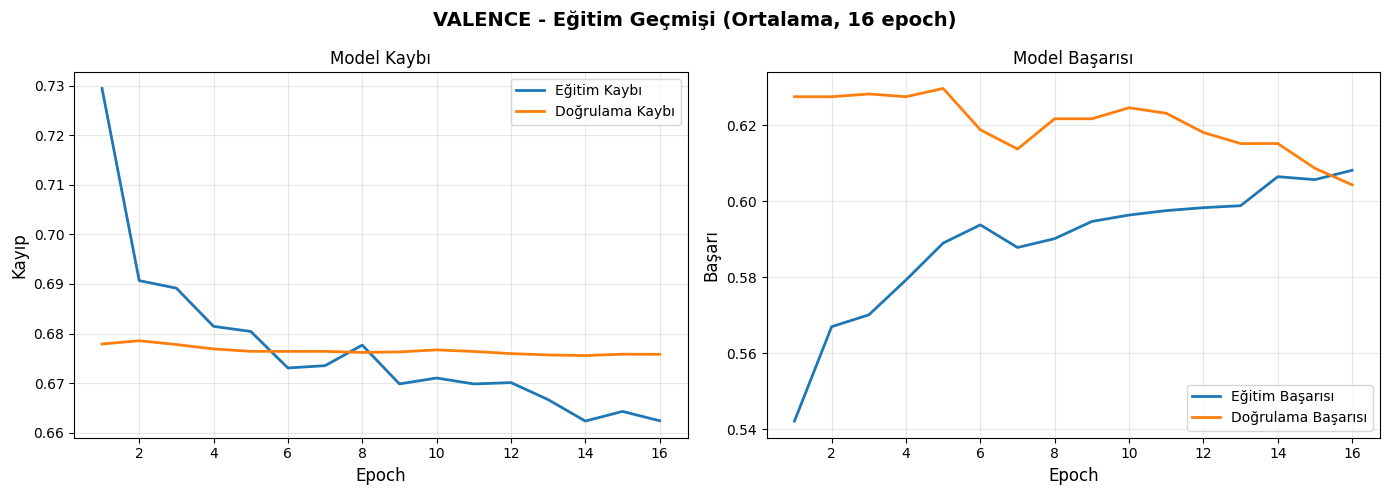

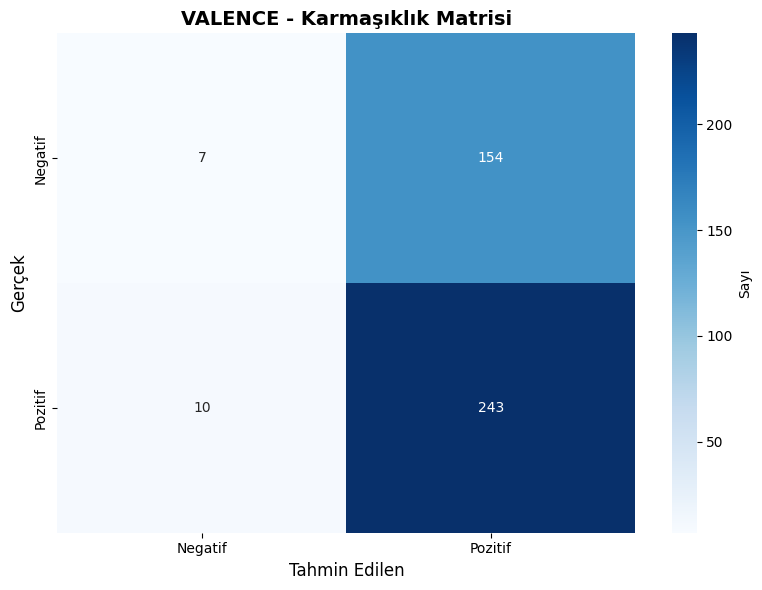

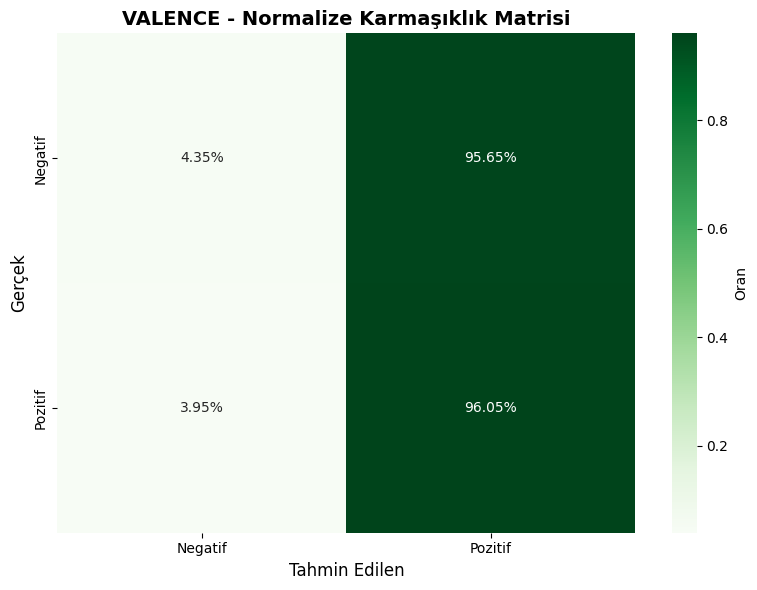


  VALENCE - SINIFLANDIRMA RAPORU

              precision    recall  f1-score   support

     Negatif     0.4118    0.0435    0.0787       161
     Pozitif     0.6121    0.9605    0.7477       253

    accuracy                         0.6039       414
   macro avg     0.5119    0.5020    0.4132       414
weighted avg     0.5342    0.6039    0.4875       414



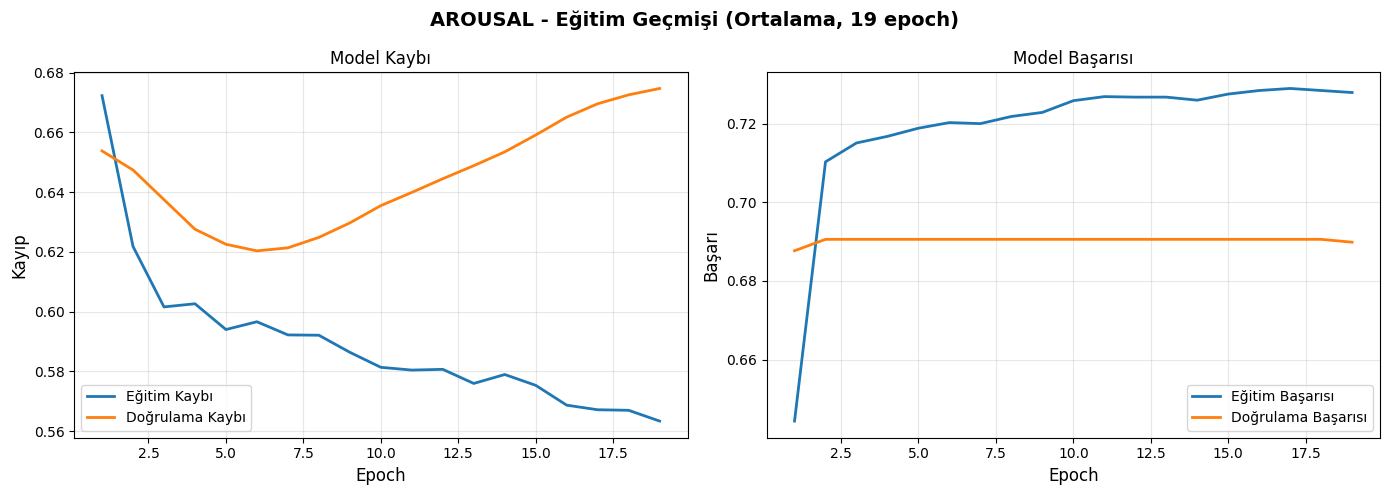

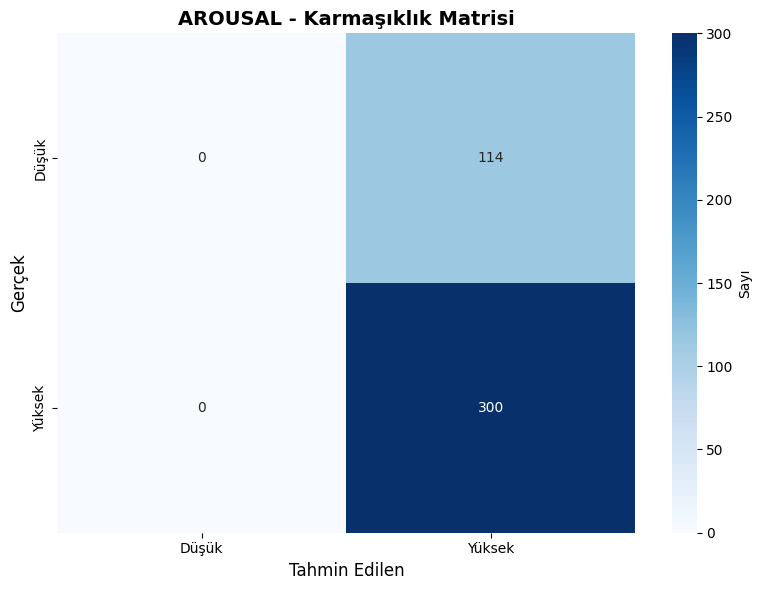

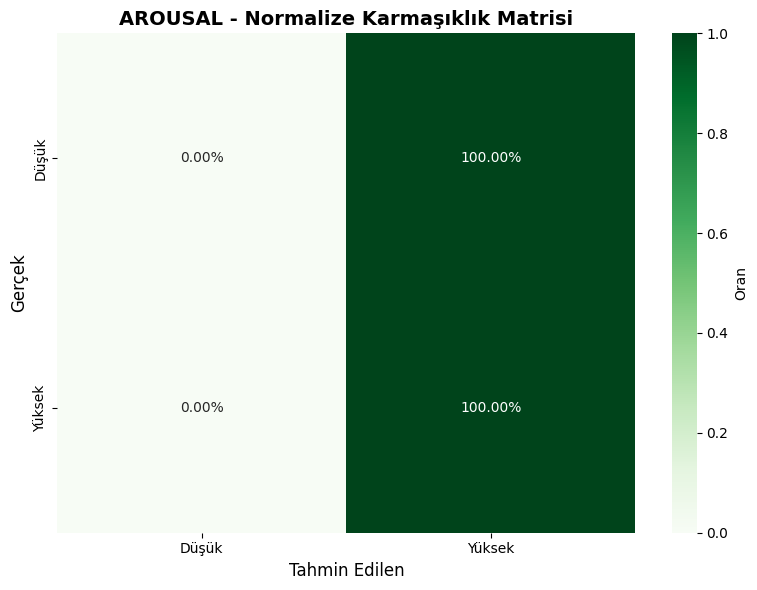


  AROUSAL - SINIFLANDIRMA RAPORU

              precision    recall  f1-score   support

       Düşük     0.0000    0.0000    0.0000       114
      Yüksek     0.7246    1.0000    0.8403       300

    accuracy                         0.7246       414
   macro avg     0.3623    0.5000    0.4202       414
weighted avg     0.5251    0.7246    0.6089       414


  FİNAL SONUÇLAR ÖZETİ

Duygu Boyutu Ortalama Accuracy (%) Ortalama F1-Score (%)
     Valence         60.39 ± 12.83         48.20 ± 15.65
     Arousal         72.46 ± 13.66         61.62 ± 18.09


✓ Notebook tamamlandı!
✓ Model ağırlıkları kaydedildi (best_model_*.h5)
✓ Sonuç grafikleri oluşturuldu


In [23]:
# Notebook'u çalıştır
if __name__ == "__main__":
    valence_results, arousal_results = main_pipeline()

    print("\n✓ Notebook tamamlandı!")
    print("✓ Model ağırlıkları kaydedildi (best_model_*.h5)")
    print("✓ Sonuç grafikleri oluşturuldu")